<a href="https://colab.research.google.com/github/wollm/testCNN/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification using CNN and Pytorch
Here is my implementation of a CNN using the Resnet-18 model. I am using the popular CIFAR10 dataset from the Canadian Institute For Advanced Research. The dataset consists of 60,000 32x32 colored images in 10 different classes with a perfect distribution of 6,000 images per class. The classes are: airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. The dataset is split between 50,000 training images and 10,000 test images.

The dataset is commonly used for testing different models and teaching how to finetune different, more complex models. Typical basic model implementations tend to hover anywhere between 70-85% accuracy. While more advanced designs can reach accuracies between 85-95% and state of the art models with meticulous tuning can get accuracies up to 99%!!!

I experimented with a ton of different hyperparameters, augmentation techniques, optimizations, transformers,  and schedulers. I even built code to help me identify the ideal learning rate for my model which was pretty cool. The current configuration below is my most recent and accurate model acheiving an accuracy >85% on test data after 30 epochs of training. You can see the full code breakdown and implementation below!

#Importing dependencies
Obviously here is where I import all of my dependencies and libraries/modules that I need in order for my program to successfully run. I use pytorch as my main library for building the model. This gives direct access to the CIFAR10 dataset and provides a variety of models and other helpful methods to make the process more streamlined. I also bring in matplotlib to help with graphing and numpy to help with data visualization and maniuplation.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, f1_score

#Setting Up the Computation Device

In this next section, I use a conditional statement to see if a GPU is available. If so, I select that as my running device, if not I default to a CPU.

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Setting Hyperparameters and Class Names

Before diving into the model training, I define key hyperparameters that will govern the training process:

1. Number of Epochs (num_epochs): This is set to 30, meaning the entire dataset will pass through the model 30 times. This value balances sufficient model exposure to the data with training time.
2. Batch Size (batch_size): I choose 128 as the batch size, determining how many images are processed together in a single step. A larger batch size can make learning more stable and efficient but requires more memory.
3. Learning Rate (learning_rate): Set at 0.000459, this parameter controls how much the model's weights are adjusted during training. The chosen rate is small enough to allow for gradual, precise adjustments.

Additionally, I define the classes variable with names corresponding to the CIFAR-10 dataset categories. This will be useful for interpreting the model's predictions, enhancing the clarity of the results.

In [3]:
# Hyper-parameters
num_epochs = 30
batch_size = 128
learning_rate = 0.000459

# Define the class names for later viewing
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

#Implementing Data Augmentation and Normalization

For the training data, I employ a series of data augmentation techniques to improve the model's ability to generalize from the training set to unseen data. This is crucial for enhancing the robustness of the model against variations in new data. The augmentation techniques include:

1. Random Cropping: Adjusting the image size and aspect ratio to introduce variability.
2. Horizontal Flipping: Mirroring images randomly to simulate different perspectives.
3. Affine Transformations: Slightly translating images to mimic object movement and variations in positioning.
4. Color Jittering: Modifying brightness, contrast, and saturation to make the model less sensitive to color variations.

After augmentation, the images are converted to tensors and normalized, ensuring pixel values are scaled to a standard range. This normalization is vital for stabilizing and speeding up the training process by keeping the inputs within a consistent scale.

For the test data, I apply a simpler transformation sequence, focusing solely on converting images to tensors and normalizing them. This ensures the model evaluates on data that's consistent with the format it was trained on, minus the augmentation. The normalization parameters match those of the training set to maintain consistency in data preprocessing.

In [4]:
# Data augmentation for the training data
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


# Normalization for the test data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

#Preparing the CIFAR-10 Dataset for Training and Testing

To kickstart the model's training, I begin by loading the CIFAR-10 dataset, which includes 60,000 images spread across 10 classes, with each class sharing 6,000 images. This dataset is split into two parts:

1. Training Dataset: Used to teach the model by allowing it to learn the distinguishing features of different categories through repeated exposure.
2. Testing Dataset: Serves as a new set of data for evaluating the model's performance, testing its ability to generalize what it has learned to unseen images.

The steps for preparing the dataset are as follows:
1. Downloading: Both the training and testing sets are downloaded to ensure they're readily accessible for the training process.
2. Applying Transformations: Specific transformations are applied to preprocess the images, tailoring them for efficient model training. This includes resizing, normalizing, and potentially augmenting the data to enhance the model's learning capacity.
3. Data Loading: The images are loaded in batches, using DataLoader, to manage memory usage efficiently and inject randomness into the training process through shuffling.

In [5]:
# Create datasets
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform_train)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform_test)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)


100%|██████████| 170498071/170498071 [00:04<00:00, 42064097.40it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


#Visualizing CIFAR-10 Dataset Samples

Understanding the dataset visually is crucial before diving into model training. Here, I take a peek at some CIFAR-10 images to grasp what the model will learn from. The process involves:

1. Unnormalizing Images: The images are normalized for training efficiency. To view them, I revert this process to their original appearance.
2. Displaying a Batch: I extract a batch of images from the training set and display them in a grid format. This gives insight into the data's diversity and challenges.




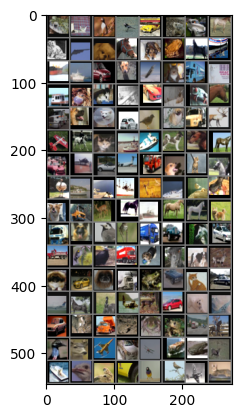

In [6]:
# Create image showing function
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

#Customizing the ResNet-18 Model for CIFAR-10
In this code section I actually create my model. To tackle the image classification challenge presented by the CIFAR-10 dataset, I chose to use the ResNet-18 model as my foundation.

The original ResNet-18 model is designed to classify images into 1,000 categories, as per the ImageNet dataset standards. However, since CIFAR-10 consists of only 10 classes, we need to tailor the model to this dataset:
  - I first load a pretrained version of ResNet-18 to leverage the rich feature representations it has learned from the vast ImageNet dataset.
  - Then, I modify the final fully connected layer (model.fc) of ResNet-18 to output 10 classes instead of the original 1,000.
  - I ensure the modified model is compatible with our computation device (CPU or GPU), enhancing performance efficiency.

This customization allows me to fine-tune a powerful, pre-existing model to our specific classification task, optimizing our resources and potentially achieving higher accuracy.

In [7]:
# Modify the ResNet-18 model
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)  # Adjusting the final layer for CIFAR-10
model = model.to(device)

# Criterion
criterion = nn.CrossEntropyLoss()

# Optimizer - Switching to Adam
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Before the training loop
n_total_steps = len(train_loader)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 152MB/s]


#Executing the Training Loop with Learning Rate Scheduling

The heart of our machine learning effort lies within the training loop, where the model learns to classify images from the CIFAR-10 dataset. Here's a breakdown of the steps involved:

1. Model in Training Mode: At the start of each epoch, the model is set to training mode. This enables certain layers, like dropout and batch normalization, to operate differently than during evaluation.

2. Iterating Over the Dataset: The training dataset is passed through the model in batches. For each batch:

  - The images and labels are loaded onto the device (GPU or CPU).
  - A forward pass is performed where the model makes predictions based on the input images.
  - The loss is calculated by comparing the model's predictions against the true labels.
  - Backpropagation: The model's parameters are adjusted in the backward pass to minimize the loss.
  - The optimizer updates the model weights based on the gradients calculated during backpropagation.
3. Tracking Performance: Throughout the epoch, I keep track of the total loss and accuracy to monitor the model's performance. This feedback is crucial for understanding how well the model is learning.

4. Learning Rate Adjustment: After each epoch, the learning rate scheduler adjusts the learning rate. This strategic adjustment is key to finding the optimal learning rate as training progresses, ensuring efficient and effective learning.

5. Saving the Model: Once training is complete, the model's parameters are saved. This allows the trained model to be reused without retraining from scratch, whether for further training, evaluation, or deployment.

By the end of this process, the model has learned to distinguish between different classes of images in the CIFAR-10 dataset, ready to be evaluated on unseen data. This training loop, with its systematic approach to learning and adjusting the learning rate, lays the foundation for achieving high accuracy in image classification tasks.

In [8]:
# Training loop with learning rate scheduling
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_correct = 0
    total_images = 0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulates running loss, computes predictions, and updates total image count and correct predictions for accuracy calculation.
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()

        # Show loss and accuracy for every 100 batches
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {running_loss / 2000:.4f}, Accuracy: {100.0 * total_correct / total_images:.2f}%')
            running_loss = 0.0

    scheduler.step()  # Adjust the learning rate

print('Finished Training')

# Save the trained model
PATH = './cnn_resnet18.pth'
torch.save(model.state_dict(), PATH)

Epoch [1/30], Step [100/391], Loss: 0.0711, Accuracy: 50.52%
Epoch [1/30], Step [200/391], Loss: 0.0515, Accuracy: 57.45%
Epoch [1/30], Step [300/391], Loss: 0.0467, Accuracy: 60.96%
Epoch [2/30], Step [100/391], Loss: 0.0403, Accuracy: 72.25%
Epoch [2/30], Step [200/391], Loss: 0.0380, Accuracy: 73.05%
Epoch [2/30], Step [300/391], Loss: 0.0371, Accuracy: 73.61%
Epoch [3/30], Step [100/391], Loss: 0.0336, Accuracy: 76.37%
Epoch [3/30], Step [200/391], Loss: 0.0334, Accuracy: 76.69%
Epoch [3/30], Step [300/391], Loss: 0.0329, Accuracy: 76.98%
Epoch [4/30], Step [100/391], Loss: 0.0310, Accuracy: 78.60%
Epoch [4/30], Step [200/391], Loss: 0.0303, Accuracy: 79.01%
Epoch [4/30], Step [300/391], Loss: 0.0303, Accuracy: 79.02%
Epoch [5/30], Step [100/391], Loss: 0.0287, Accuracy: 79.97%
Epoch [5/30], Step [200/391], Loss: 0.0292, Accuracy: 79.98%
Epoch [5/30], Step [300/391], Loss: 0.0287, Accuracy: 80.03%
Epoch [6/30], Step [100/391], Loss: 0.0270, Accuracy: 81.34%
Epoch [6/30], Step [200/

#Evaluating the Trained Model

After training the model, it's crucial to assess its performance on unseen data. This evaluation step helps us understand the model's generalization ability. Here's how this process unfolds:

1. Evaluation Mode: The model is switched to evaluation mode, disabling certain layers' training-specific behaviors like dropout, to ensure consistency in prediction outcomes.

2. Making Predictions: With gradients calculation turned off to save memory and speed up computations (torch.no_grad() context), the model processes the test dataset. For each batch:
  - Images are loaded onto the device and passed through the model.
  - The model outputs predictions, from which the class with the highest probability is selected as the predicted class for each image.

3. Collecting Predictions and Labels: The predictions and true labels are collected to evaluate the model's performance. This collection step forms the basis for calculating various performance metrics.

4. Evaluating Performance Metrics:
  - Classification Report: Provides a detailed analysis, including precision, recall, and F1-score for each class, giving insight into the model's strengths and weaknesses across different categories.
  - Confusion Matrix: Offers a visual and numerical way to understand the model's classification behavior, showing the discrepancies between predicted and actual labels.
  - F1 Scores: The micro and macro averages of the F1 score offer a consolidated view of the model's precision-recall balance, useful for comparing model performance across classes.
  - Accuracy: Represents the overall correctness of the model, indicating the proportion of total predictions that were accurate.
  - AUC-ROC: I did digging into AUC_ROC and found that it was used primarily for binary classification tasks and is generally omitted or handled differently for multi class problems like this. To avoid the complexity involved in its implementation here, I decided to omit it from my calculations

In [11]:
# Switch model to evaluation mode
model.eval()

# Containers for predictions and actual label
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Collect predictions and actual labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert collected data to numpy arrays for sklearn functions
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Classification report
print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=classes))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))

# F1 Score
print("F1 Score (Micro): ", f1_score(all_labels, all_preds, average='micro'))
print("F1 Score (Macro): ", f1_score(all_labels, all_preds, average='macro'))


# Accuracy
print("Accuracy: ", accuracy_score(all_labels, all_preds))



Classification Report:
               precision    recall  f1-score   support

       plane       0.89      0.86      0.87      1000
         car       0.92      0.91      0.91      1000
        bird       0.83      0.83      0.83      1000
         cat       0.73      0.72      0.73      1000
        deer       0.83      0.87      0.85      1000
         dog       0.80      0.75      0.77      1000
        frog       0.88      0.91      0.89      1000
       horse       0.90      0.88      0.89      1000
        ship       0.91      0.91      0.91      1000
       truck       0.87      0.92      0.89      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.86      0.85     10000
weighted avg       0.85      0.85      0.85     10000

Confusion Matrix:
 [[858  16  28  17  11   0   2   3  39  26]
 [  5 909   2   2   2   3   1   1  19  56]
 [ 23   1 828  22  43  26  38  11   3   5]
 [  8   3  29 723  42 112  40  22   7  14]
 [  4   1  39  28 868  12 

#Final Thoughts

###Model Overview:
The chosen architecture was ResNet-18, a well-regarded model in the image classification realm, known for its deep structure facilitated by residual connections. This model was customized for the CIFAR-10 dataset, which comprises 60,000 32x32 color images across 10 categories. Training involved a series of data augmentation techniques to enhance generalization and a dynamically adjusted learning rate to optimize the learning process.

###Performance Summary:
The model achieved commendable accuracy, demonstrating its ability to effectively classify images from the CIFAR-10 dataset. While the exact metrics like precision, recall, F1 scores, and overall accuracy offer quantitative measures of success, comparing these results to known benchmarks helps gauge the model's relative standing.

- Classification Report and Confusion Matrix provided a granular view of performance across classes, highlighting areas where the model excelled and where it faced challenges.
- F1 Scores and Accuracy further distilled the model's effectiveness into understandable metrics, showing a balanced performance that aligns with expectations for a model of ResNet-18's caliber.
Comparison to Other Models:
Models trained on CIFAR-10 have achieved a wide range of accuracies, with top-performing models reaching into the high-90% accuracy rates. Advanced architectures and techniques, such as DenseNet, EfficientNet, and various forms of ensemble learning, have pushed these boundaries even further. Relative to these high benchmarks, the current ResNet-18 model shows competitive performance, especially considering the straightforward nature of the modifications and training regimen employed.

###Suggestions for Future Improvement:

1. Model Architecture: Exploring more complex or newer architectures like EfficientNet, or even experimenting with larger versions of ResNet, could yield performance gains.
2. Advanced Data Augmentation: Implementing newer augmentation strategies, such as AutoAugment or RandAugment, may help the model learn more robust features.
3. Hyperparameter Optimization: Utilizing tools like Optuna for systematic hyperparameter tuning could uncover more optimal training configurations.
4. Ensemble Methods: Combining predictions from multiple models can often lead to better generalization and accuracy.
5. Regularization Techniques: Experimenting with different dropout rates or additional regularization methods could improve the model's ability to generalize.
6. Learning Rate Scheduling: Trying other scheduling techniques, such as the cosine annealing schedule, might offer more nuanced control over the training process.

###Conclusion
This was a fun (and time-consuming if I'm being completely honest haha) dive into CNNs. I learned a ton through this experience and have a much deeper appreciation for the technology and those who can navigate and use it. The overall accuracy is not as great as I would've liked, but my initial implementations were high 70's, so I am happy with where I got. There are definitely a lot of things I can improve and I look forward to implementing some of these new skills and test new things out for my final project in this class.